In [2]:
"""
Goal here is to implement a bunch of shareable image processing functions and see how
the differently processed images affect the accuracy of the machine learning. I'll use
one relatively standard machine learning algorithm with multiple different pre-processing
methods to evaluate their effect on the accuracy.

File is split into two parts: Generic image functions, and script to run analysis
"""

############################
#Imports

import os
import glob
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torchvision.models import vgg16
import torchvision.transforms as transforms
from tqdm.auto import tqdm
import cv2
from sklearn.decomposition import PCA

############################
#Generic image processing functions

#Converts any-channel image (represented as numpy array) to n-channel image by slicing off extras
def truncateChannels(img, n=3):
    rows, cols, _ = img.shape
    result = np.empty((rows, cols, n))
    for row in range(rows):
        for col in range(cols):
            result[row, col] = img[row, col][:n]    
    return result
            
#Crops image (represented as numpy array) for input to VGG16 (and others) in most basic way possible;
#Starts at top-left corner and crops original image down to one by just slicing off excess
def singleCrop(img, size=224):
    return img[:size, :size]

#Crops image (represented as numpy array) into as many smaller images as possible for input to VGG16
#while maintaining no overlap between them. So it divides the image into 224 x 224 sections
#Returns these smaller images together in a one-dimensional list
def multiCrop(img, size=224):
    rows, cols, _ = img.shape
    i, j = 0, 0
    result = []
    #Cut off the last increments since they will be less than [size] from the edge of the image
    #Note the +1s handle an off-by-one error in the edge case where image dimensions are an
    #integer multiple of [size]
    for i in (range(0, rows + 1, size)[:-1]):
        for j in (range(0, cols + 1, size)[:-1]):
            result.append(img[i:i + size, j:j + size])
            
    return result

#Pretty self-explanatory; assumes the input is a list
def flatten(L):
    result = []
    for subL in L:
        for item in subL:
            result.append(item)
    return result

#Rounds the integer n to the nearest multiple of increment
def roundTo(n, increment):
    excess = n % increment
    if excess == 0:
        return n
    else:
        if (increment - excess) > excess:
            return n - excess
        else:
            return n - excess + increment

#Apply multiCrop, then truncate alpha channel on all of the resulting images
def truncateMulti(original):
    return list(map(lambda img : truncateChannels(img), multiCrop(original)))

#### All of the following functions will be designed so that they just take in the image path,
#so they can all be used in the same spot in my script and I can interchange them easily.
#They each comprise a different procedure for getting from path to all the final images that
#can be extracted from that path.

#Simply crop the original image into as many smaller images as possible without changing
#any of its information
def standardPrep(path):
    original = np.array(Image.open(path))
    return list(map(lambda img : truncateChannels(img), multiCrop(original)))

#Resize the original image to the nearest multiple of 224 (or whatever size) so no information
#is left "unused".
#The default filter used for resizing is a "bicubic" filter, but this can be changed. May be
#worth trying different types if this ends up distorting results of training significantly
def resizePrep(path, size=224):
    original = Image.open(path)
    w, h = original.width, original.height
    newW, newH = roundTo(w, size), roundTo(h, size)
    resized = np.array(original.resize((newW, newH)))
    return list(map(lambda img : truncateChannels(img), multiCrop(resized)))

#Uniformly rotate some of the images (by increments of 90 degrees) resulting from regular
#multicropping, so the data is changed but none of it is duplicated
def uniformRotatePrep(path):
    original = np.array(Image.open(path))
    images = list(map(lambda img : truncateChannels(img), multiCrop(original)))
    for i in range(len(images)):
        angle = (i % 4) * 90
        #Just to help speed things up
        if angle == 0:
            continue
        old = images[i]
        asImage = Image.fromarray(np.uint8(old))
        new = np.array(asImage.rotate(angle))
        images[i] = new
    return images

#Rotate all of the original images 3 times and then use regular multicropping, so there may be
#some slightly different data if the dimensions aren't an even multiple of 224 (or whatever size)
#but overall the uniqueness of the images is dubious
def multiRotatePrep(path):
    original = Image.open(path)
    images = truncateMulti(np.array(original))
    for i in range(1, 4):
        rotated = original.rotate(90 * i)
        images.extend(truncateMulti(np.array(rotated)))
    
    return images

#Apply a bilateral filter over the original images and then crop them using regular multicropping
def bilateralPrep(path, diameter=9, sigmaColor=100, sigmaSpace=100):
    original = Image.open(path)
    truncated = np.uint8(truncateChannels(np.array(original)))
    #I played a bit with these parameters and looking at the results before settling on these
    #values, could be worth investigating them further
    filtered = cv2.bilateralFilter(truncated, diameter, sigmaColor, sigmaSpace)
    return multiCrop(filtered)

#Apply a dilation filter over the original images and then crop them using regular multicropping
def dilatePrep(path, kernelShape=cv2.MORPH_CROSS, kernelSize=(3, 3)):
    original = Image.open(path)
    truncated = np.uint8(truncateChannels(np.array(original)))
    #kernelShape can be one of cv2.MORPH_RECT, cv2.MORPH_CROSS, and cv2.MORPH_ELLIPSE
    #Chose one sort of arbitrarily, seemed like the least distorted image of the 3 options, would
    #be worth looking into their effects more in the future
    #kernelSize chosen equally arbitrarily, also can choose to make it not square...
    kernel = cv2.getStructuringElement(kernelShape, kernelSize)
    filtered = cv2.dilate(truncated, kernel)
    return multiCrop(filtered)

#Apply histogram equalization over the original images and then crop them using regular multicropping
#Strongly suspect it is not going to be helpful at all for this particular dataset, but we'll try it
def equalizePrep(path):
    original = Image.open(path).convert(mode="L")
    converted = np.uint8(np.array(original))
    equalized = cv2.equalizeHist(converted)
    #This is super scuffed but... meh
    reconverted = np.array(Image.fromarray(equalized).convert(mode="RGB"))
    return multiCrop(reconverted)

#Combination of bilateral and uniform rotate, since they performed the best independently
def optimalPrep(path):
    filtered = bilateralPrep(path)
    for i in range(len(filtered)):
        angle = (i % 4) * 90
        #Just to help speed things up
        if angle == 0:
            continue
        old = filtered[i]
        asImage = Image.fromarray(np.uint8(old))
        new = np.array(asImage.rotate(angle))
        filtered[i] = new
    return filtered

############################
#Script to run the actual analysis on THIS data

#Load the excel file
csvPath = os.path.join("..", "data", "TMST", "TMST_label.csv")
with open(csvPath, 'r') as f:
    contents = f.read()
    labelDict = dict()
    for line in contents.splitlines()[1:]:
        imgID, label = line.split(',')
        labelDict[imgID] = label

#Let's make a helper function to help us find data files
def get_files(file_directory, extension='*.bmp'):
    """
    Arguments:
        file_directory: path to directory to search for files
        extension: desired file type, default *.bmp (bitmap)
    
    Return:
        files: list of files in file_directory with extension
    """
    files = glob.glob(os.path.join(file_directory, extension))
    return files

#Remove all characters but the ID digits
def onlyDigits(s):
    result = ""
    filtered = [c for c in s if c.isdigit()]
    for c in filtered:
        result += c
    return result

#Extract the image ID from its path
def getID(prefix, path):
    return onlyDigits(path[:-4].split(prefix)[1])

# define our model
class VGG_fc1(nn.Module):
    def __init__(self):
        super(VGG_fc1, self).__init__()
        self.features = vgg16(pretrained=True).features # convolutional layers
        self.avgpool = vgg16(pretrained=True).avgpool
        self.fc1 = vgg16(pretrained=True).classifier[0] # first layer of classifier
        
    def forward(self, x):
        #Extract first fully connected feature vector
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x
    
model = VGG_fc1().eval() # turn model into evaluation mode

# transform from image to the input of CNN, follow the same procedure as ImageNet

transform = transforms.Compose([
    transforms.ToTensor(), # convert pixel values to the range of [0,1]
    # normalize the pixel values according to the mean and std of ImageNet
    transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                         std=(0.229, 0.224, 0.225))])

#I have modified this so that it now expects as input a numpy array of size (224 x 224 x 3), which will be
#the result type of many of my image pre-processing functions
def get_feature(img):
    '''Run a pytorch Tensor through VGG16 and get feature vector '''
    img = transform(img)
    img = img.unsqueeze(0) # make the tensor into single batch tensor with shape [1, 3, 224, 224]
    img = img.to(dtype=torch.float)
    feature = model(img) # get feature
    feature = feature.detach().numpy() # detach the gradient, convert to numpy array
    return feature.flatten()

dataPath = os.path.join("..", "data", "TMST", "images")
imagePaths = get_files(dataPath, extension="*.png")

data = pd.DataFrame(data=imagePaths, columns=["imagePath"])
data["imageID"] = [i for i in map(lambda s : getID(dataPath, s), data["imagePath"])]
data["label"] = [labelDict[i] for i in data["imageID"]]

def processSet(prepFn):
    expandedIDs = []
    expandedLabels = []
    expandedVectors = []
    labelCounts = dict()
    for i in tqdm(data.index):
        #If I crop every single image into as many as possible we get... way too many to do on my laptop.
        #So I'll reduce all of them to the same amount as the classes with the least images (5)
        curLabel = data.loc[i]["label"]

        if curLabel in labelCounts:
            if labelCounts[curLabel] >= 5:
                continue
            else:
                labelCounts[curLabel] += 1
        else:
            labelCounts[curLabel] = 1

        preppedImages = prepFn(data.loc[i]["imagePath"])
        vectors = [get_feature(img) for img in preppedImages]
        expandedVectors.append(vectors)

        numAdded = len(preppedImages)
        expandedIDs.append([data.loc[i]["imageID"]] * numAdded)
        expandedLabels.append([curLabel] * numAdded)

    expandedIDs = flatten(expandedIDs)
    expandedLabels = flatten(expandedLabels)
    expandedVectors = flatten(expandedVectors)
    assert(len(expandedIDs) == len(expandedLabels) == len(expandedVectors))

    expandedData = pd.DataFrame(data=list(zip(expandedIDs, expandedLabels, expandedVectors)),
                               columns=["imageID", "label", "featureVector"])
    print(prepFn.__name__, len(expandedData["featureVector"]))
    savePath = os.path.join("..", "data", "TMST", prepFn.__name__ + ".pkl")
    expandedData.to_pickle(savePath)


In [2]:
prepFns = [optimalPrep]
for fn in prepFns:
    processSet(fn)

  0%|          | 0/660 [00:00<?, ?it/s]

optimalPrep 2380


11100
9600
..\data\TMST\bilateralPrep score: 0.23645833333333333


C:\Users\docto\Documents\NextGenFellows-master\NextGenFellows-master\notebooks\..\helper\visualize.py:120: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['' for i in range(n)], minor=False, fontsize=fs)
C:\Users\docto\Documents\NextGenFellows-master\NextGenFellows-master\notebooks\..\helper\visualize.py:121: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['' for i in range(n)], minor=False, fontsize=fs)


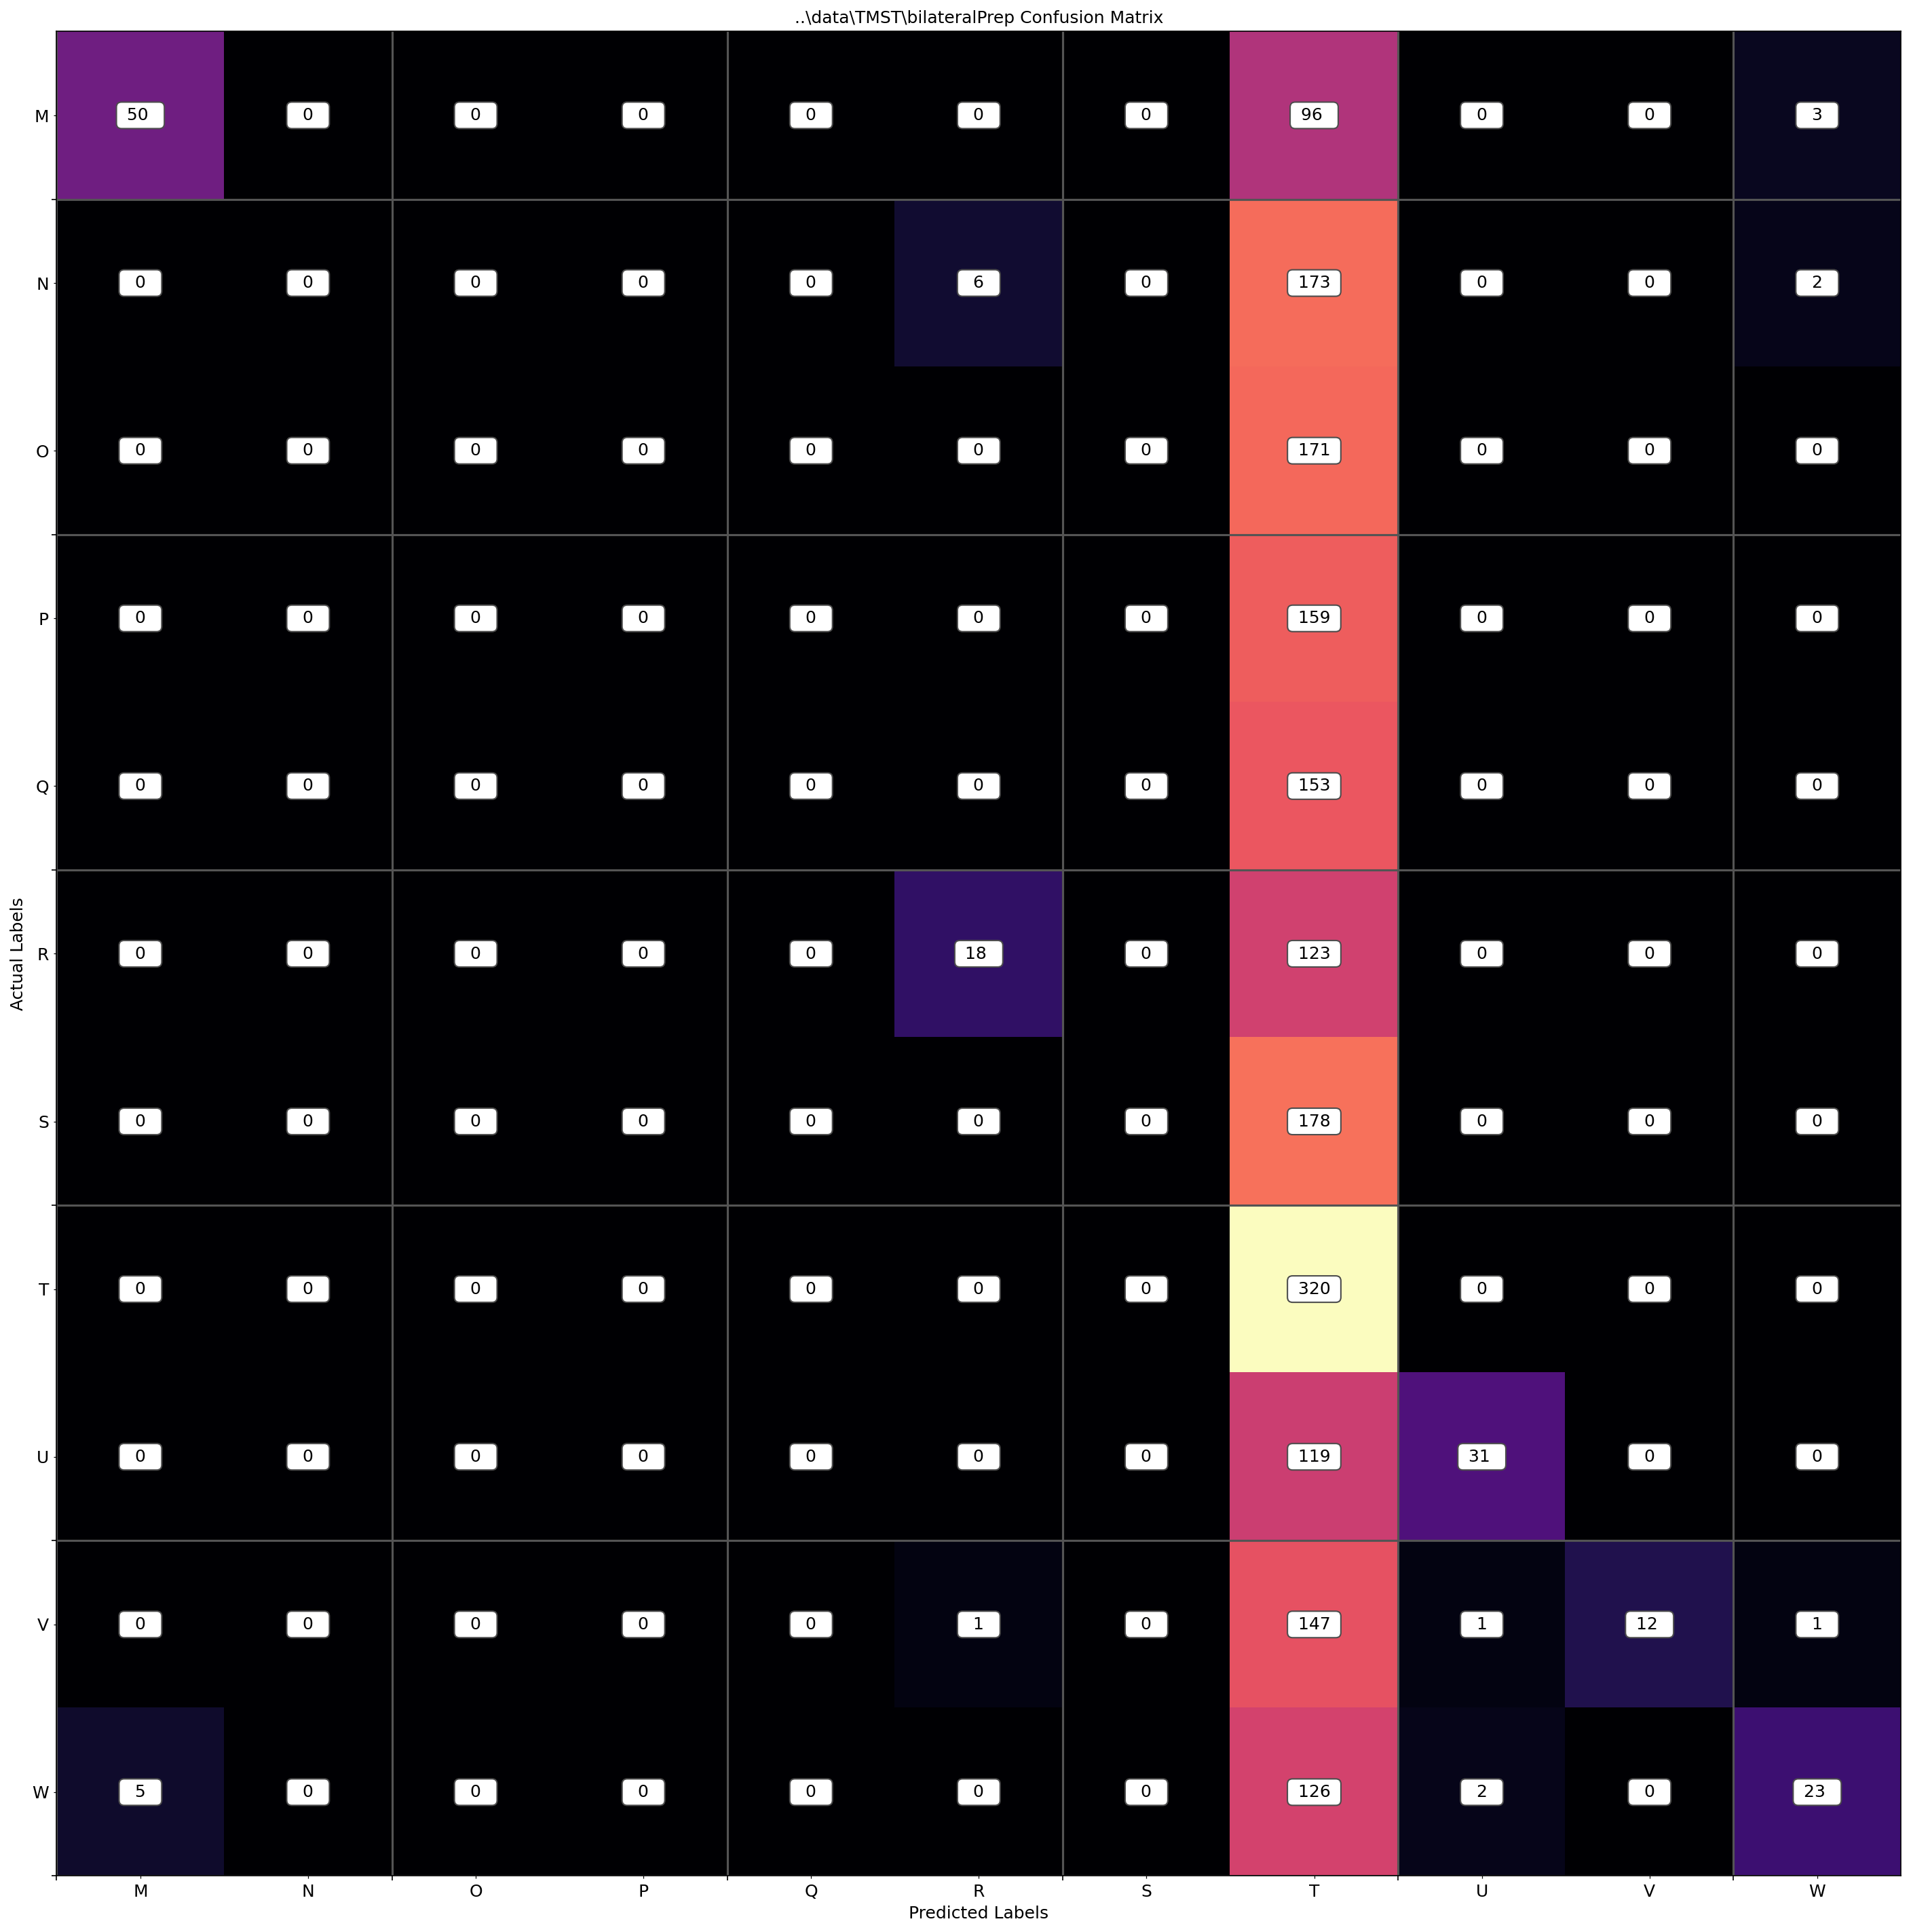

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from helper import visualize as vis

def doAnalysis(picklePath):
    labelSubset = "M,N,O,P,Q,R,S,T,U,V,W".split(',')
    df = pd.read_pickle(picklePath)
    print(len(df["featureVector"]))
    
    #Extra part for separating out only the classes with enough data
    vectors = []
    labels = []
    for i in range(len(df["label"])):
        if df["label"][i] in labelSubset:
            vectors.append(df["featureVector"][i])
            labels.append(df["label"][i])
    print(len(vectors))
    trainFeatures, testFeatures, trainLabels, testLabels = train_test_split(vectors,
                                                                           labels,
                                                                           test_size=0.2,
                                                                           random_state=617,
                                                                           shuffle=True)
    trainFeatures = np.array(list(trainFeatures))
    testFeatures = np.array(list(testFeatures))
    
    pca50 = PCA(n_components=50, svd_solver="randomized", random_state=616)
    pca50.fit(trainFeatures)
    trainFeatures = pca50.transform(trainFeatures)
    testFeatures = pca50.transform(testFeatures)
    
    classifier = SVC(kernel="rbf", gamma="auto", random_state=618)
    classifier.fit(trainFeatures, trainLabels)
    
    root = picklePath[:-4]
    savePath = root + "cm"
    print(root + " score: " + str(classifier.score(testFeatures, testLabels)))
    cm = confusion_matrix(y_true=testLabels, y_pred=classifier.predict(testFeatures))
    fig, ax = plt.subplots(1, 1, figsize=(24, 24), dpi=150)
    vis.pretty_cm(cm, ax0=ax, labelnames=labelSubset)
    ax.set_title(root + " Confusion Matrix")
    plt.savefig(savePath)
    #train, get score, maybe a confusion matrix...
    
loadPath = os.path.join("..", "data", "TMST")
paths = [os.path.join(loadPath, "bilateralPrep.pkl")]
for item in paths:
    doAnalysis(item)

In [4]:
temp = pd.read_pickle(savePath)
temp.head()

NameError: name 'savePath' is not defined

In [ ]:
labelCounts = dict()
for item in data["label"]:
    if item in labelCounts:
        labelCounts[item] += 1
    else:
        labelCounts[item] = 1

print(labelCounts)